In [3]:
!pip install transformers datasets scikit-learn torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 122.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 97.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 41.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 111.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjit

In [1]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm


In [2]:
# 1. Dataset Class
class ReviewDataset(Dataset):
    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, item):
        review = str(self.reviews[item])
        target = self.targets[item]

        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long)
        }


In [3]:
# 2. Model
class SentimentClassifier(nn.Module):
    def __init__(self, model_name, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(model_name)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        pooled_output = outputs.pooler_output
        return self.out(self.drop(pooled_output))


In [4]:
# 3. Training Function
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler=None):
    model = model.train()
    losses = []
    correct = 0

    for batch in tqdm(data_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        targets = batch['targets'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)

        correct += torch.sum(preds == targets)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        if scheduler:
            scheduler.step()

    return correct.double() / len(data_loader.dataset), sum(losses) / len(losses)


In [5]:
# 4. Evaluation Function
def eval_model(model, data_loader, loss_fn, device):
    model = model.eval()
    losses = []
    correct = 0
    predictions = []
    true_labels = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            targets = batch['targets'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, targets)

            correct += torch.sum(preds == targets)
            losses.append(loss.item())

            predictions.extend(preds.cpu())
            true_labels.extend(targets.cpu())

    return correct.double() / len(data_loader.dataset), sum(losses) / len(losses), predictions, true_labels


In [6]:

# 5. Plotting Function
def plot_metrics(train_acc, train_loss):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_acc, label='Train Accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(train_loss, label='Train Loss')
    plt.legend()
    plt.show()

In [7]:
# 6. Inference Function
def predict_sentiment(sentence, model, tokenizer, max_len, device):
    model.eval()
    inputs = tokenizer.encode_plus(
        sentence,
        add_special_tokens=True,
        max_length=max_len,
        return_token_type_ids=False,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)
    output = model(input_ids, attention_mask)
    _, prediction = torch.max(output, dim=1)
    return prediction.item()


In [8]:
# 7. Load & Prepare Data
MODEL_NAME = 'bert-base-cased'
MAX_LEN = 160
BATCH_SIZE = 16
EPOCHS = 10
LR = 2e-5
RANDOM_SEED = 42
NUM_CLASSES = 3


In [9]:
torch.manual_seed(RANDOM_SEED)
df = pd.read_csv("/content/reviews.csv")
df = df.dropna()
df['label'] = df['score'].apply(lambda x: 0 if x < 3 else 1 if x == 3 else 2)

train_texts, temp_texts, train_labels, temp_labels = train_test_split(df['content'], df['label'], test_size=0.2, random_state=RANDOM_SEED)
val_texts, test_texts, val_labels, test_labels = train_test_split(temp_texts, temp_labels, test_size=0.5, random_state=RANDOM_SEED)

tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

train_dataset = ReviewDataset(train_texts.values, train_labels.values, tokenizer, MAX_LEN)
val_dataset = ReviewDataset(val_texts.values, val_labels.values, tokenizer, MAX_LEN)
test_dataset = ReviewDataset(test_texts.values, test_labels.values, tokenizer, MAX_LEN)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [10]:
model = SentimentClassifier(MODEL_NAME, NUM_CLASSES)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

optimizer = AdamW(model.parameters(), lr=LR)
loss_fn = nn.CrossEntropyLoss().to(device)


model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Epoch 1/10


100%|██████████| 232/232 [00:46<00:00,  5.04it/s]


Train Loss: 0.8359 | Accuracy: 0.6402
Epoch 2/10


100%|██████████| 232/232 [00:46<00:00,  4.99it/s]


Train Loss: 0.6307 | Accuracy: 0.7412
Epoch 3/10


100%|██████████| 232/232 [00:47<00:00,  4.86it/s]


Train Loss: 0.4591 | Accuracy: 0.8186
Epoch 4/10


100%|██████████| 232/232 [00:47<00:00,  4.87it/s]


Train Loss: 0.3830 | Accuracy: 0.8475
Epoch 5/10


100%|██████████| 232/232 [00:47<00:00,  4.87it/s]


Train Loss: 0.2669 | Accuracy: 0.9009
Epoch 6/10


100%|██████████| 232/232 [00:47<00:00,  4.87it/s]


Train Loss: 0.1781 | Accuracy: 0.9339
Epoch 7/10


100%|██████████| 232/232 [00:47<00:00,  4.87it/s]


Train Loss: 0.1227 | Accuracy: 0.9563
Epoch 8/10


100%|██████████| 232/232 [00:47<00:00,  4.87it/s]


Train Loss: 0.0818 | Accuracy: 0.9741
Epoch 9/10


100%|██████████| 232/232 [00:47<00:00,  4.87it/s]


Train Loss: 0.0553 | Accuracy: 0.9806
Epoch 10/10


100%|██████████| 232/232 [00:47<00:00,  4.87it/s]


Train Loss: 0.0625 | Accuracy: 0.9754


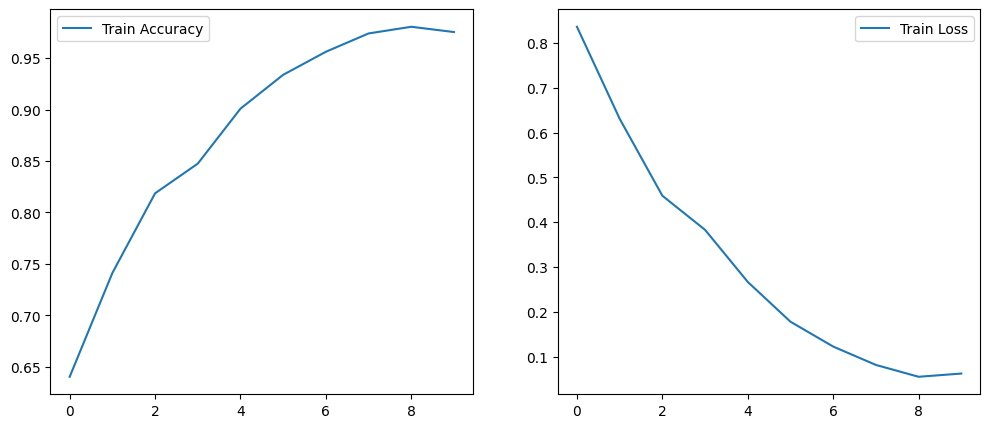

In [11]:

# 9. Train
train_accuracies, train_losses = [], []
for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1}/{EPOCHS}")
    acc, loss = train_epoch(model, train_loader, loss_fn, optimizer, device)
    train_accuracies.append(acc.item())
    train_losses.append(loss)
    print(f"Train Loss: {loss:.4f} | Accuracy: {acc:.4f}")

plot_metrics(train_accuracies, train_losses)



Test Accuracy: 0.6595 | Loss: 1.8216

Classification Report:
              precision    recall  f1-score   support

    Negative       0.77      0.82      0.80       233
     Neutral       0.33      0.42      0.37        91
    Positive       0.77      0.54      0.64       140

    accuracy                           0.66       464
   macro avg       0.62      0.59      0.60       464
weighted avg       0.68      0.66      0.66       464



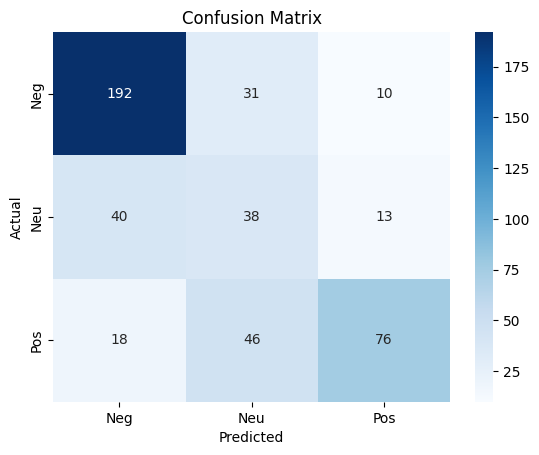

In [12]:
# 10. Evaluation on Test
acc, loss, preds, labels = eval_model(model, test_loader, loss_fn, device)
print(f"\nTest Accuracy: {acc:.4f} | Loss: {loss:.4f}")
print("\nClassification Report:")
print(classification_report(labels, preds, target_names=['Negative', 'Neutral', 'Positive']))

cm = confusion_matrix(labels, preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Neg', 'Neu', 'Pos'], yticklabels=['Neg', 'Neu', 'Pos'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [14]:

def testing_interface(sentence):
  pred = predict_sentiment(sentence, model, tokenizer, MAX_LEN, device)
  label_map = {0: "Negative", 1: "Neutral", 2: "Positive"}
  print("\nSentence:", sentence)
  print("Predicted Sentiment:", label_map[pred])
  return

In [16]:
testing_interface('i love the interface of the application')


Sentence: i love the interface of the application
Predicted Sentiment: Positive


In [15]:
testing_interface('i love this app but graphics are not good')


Sentence: i love this app but graphics are not good
Predicted Sentiment: Neutral


In [17]:
testing_interface('i hate this app')


Sentence: i hate this app
Predicted Sentiment: Negative
